In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
bs = 32

In [3]:
path = untar_data(URLs.PETS); 
path

PosixPath('/home/bf/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images')]

In [5]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames =  get_image_files(path_img)
fnames[:5]

[PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_68.jpg'),
 PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images/Russian_Blue_24.jpg'),
 PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_151.jpg'),
 PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images/Birman_142.jpg'),
 PosixPath('/home/bf/.fastai/data/oxford-iiit-pet/images/Sphynx_245.jpg')]

In [7]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [8]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                  size=224, bs=bs).normalize(imagenet_stats)

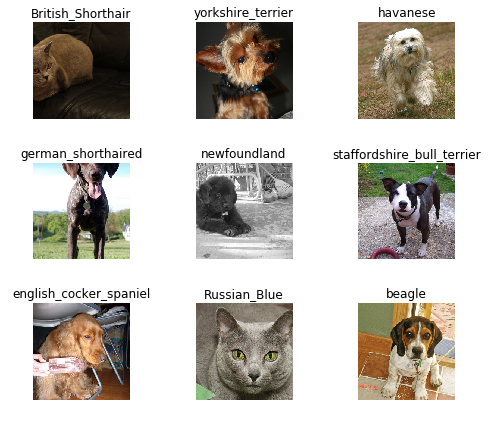

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [11]:
data.c == len(data.classes)

True

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16().mixup()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02


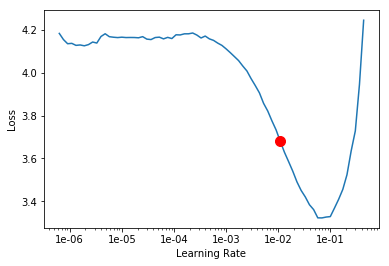

In [18]:
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.852140,0.452417,0.128552,00:49
1,1.496575,0.327982,0.085927,00:49
2,1.361880,0.282131,0.071042,00:49
3,1.303092,0.271422,0.073072,00:50


In [20]:
learn.save('stage-1')

In [23]:
learn = learn.to_fp32()

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

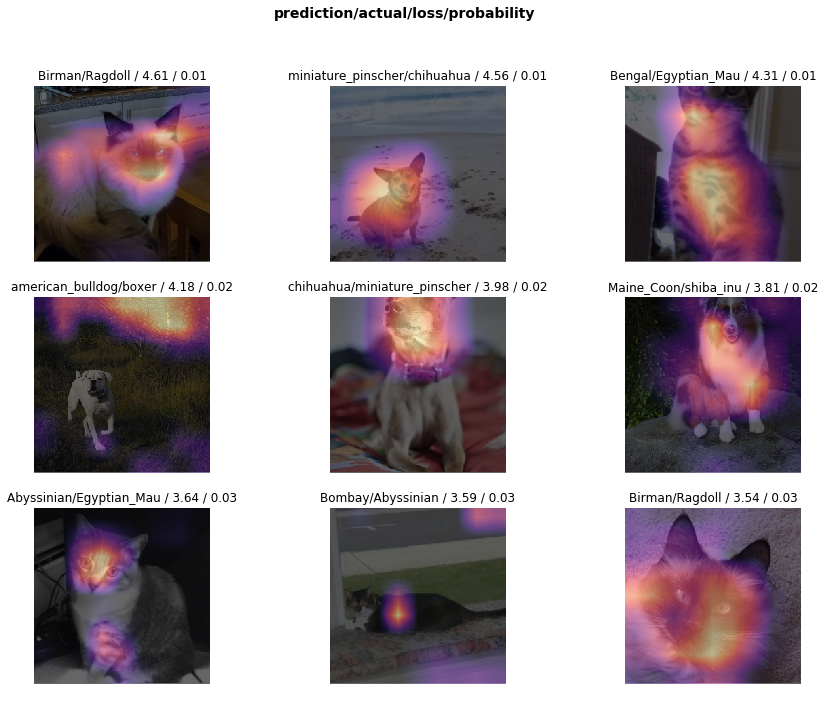

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

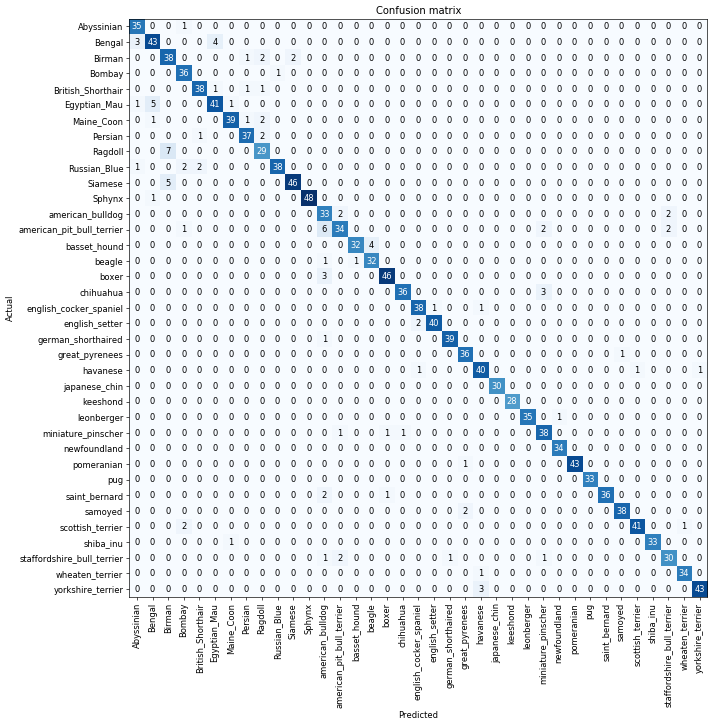

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Siamese', 'Birman', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('basset_hound', 'beagle', 4),
 ('Bengal', 'Abyssinian', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Birman', 'Ragdoll', 2),
 ('Birman', 'Siamese', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('saint_bernard', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('scottish_terrier', 'Bombay', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

In [28]:
learn = learn.to_fp16()

In [29]:
learn.unfreeze()

In [30]:
learn.load('stage-1');

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


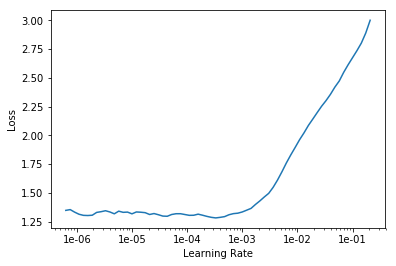

In [32]:
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.286591,0.260158,0.069012,01:05
1,1.236860,0.255498,0.068336,01:05
